# Exercise 18

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd

## a)

In [3]:
df = pd.read_csv('temperatures_dortmund.csv')
df

,Date,Time,Measurement,Temperature
0,01.01.2000,00:00,2000.000000,3.0
1,01.01.2000,00:15,2000.000028,3.0
2,01.01.2000,00:30,2000.000057,3.0
3,01.01.2000,00:45,2000.000085,3.0
4,01.01.2000,01:00,2000.000114,3.0
...,...,...,...,...
307885,31.12.2008,23:10,2008.999905,-4.0
307886,31.12.2008,23:20,2008.999924,-3.0
307887,31.12.2008,23:30,2008.999943,-3.0
307888,31.12.2008,23:40,2008.999962,-4.0


Fourier Analyse ist nicht möglich, da die Messdaten nicht äquidistant genommen wurden. Lomb-Scargle ist jedoch anwendbar.

## b)
Vorbereiten des Datensatzes

In [4]:
df = df.dropna() # drop all NaN entries
df = df[df.Measurement < 2009] # some entries have comma at wrong place, causing time > 2009

## c)

Anwenden von lomb scargle. Frequenzen mit Periodendauern im Tage/Wochen/Monate Bereich können nicht
aufgelöst werden, teste also zwischen f=0 (konstante Temperatur) und f=2. Für alle f>2 liefert
lomb scargle keinen Beitrag.

In [5]:
from scipy.signal import lombscargle

data = df.to_numpy()

temp = data[:,3]
time = data[:,2]

n_frequencies = 1000
f = np.linspace(0.01, 2, n_frequencies)

pgram = lombscargle(time, temp, 2*np.pi*f, normalize=True)

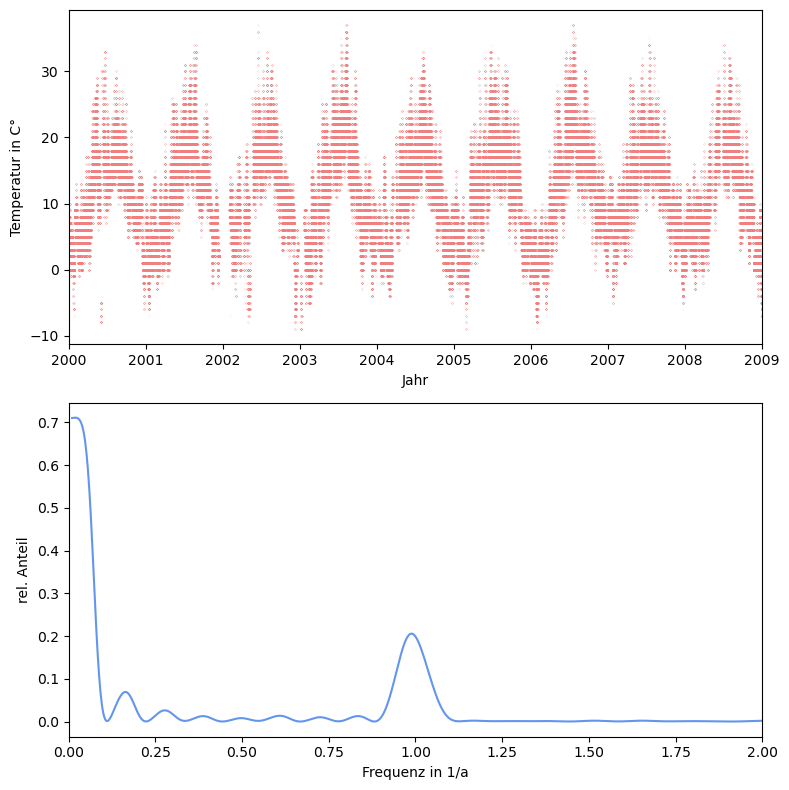

In [6]:
fig, ax = plt.subplots(2,1, figsize=(8, 8))

ax[0].plot(time, temp, marker = ".", ms = 0.1, lw = 0, c = "lightcoral")
ax[0].set_xlim(2000, 2009)
ax[0].set_xlabel("Jahr")
ax[0].set_ylabel("Temperatur in C°")

ax[1].plot(f, pgram, c = "cornflowerblue")
ax[1].set_xlim(0, 2)
ax[1].set_xlabel("Frequenz in 1/a")
ax[1].set_ylabel("rel. Anteil")

fig.tight_layout()

Es ergibt sich ein Peak bei einem Jahr, der zu erwarten war. Der größte Anteil fällt auf f=0, was aufgrund des konstanten Mittelwertes der Temperatur zu Erwarten ist.
Die periodischen Temperaturschwankungen eines Tages können jedoch nicht aufgelöst werden.
Diese wären im Frequenzbereich von ca. 365 zu Erwarten, jedoch ist der Plot ab ca. 2 konstant Null.

## d)
1. Gridding

In [7]:
time.max()

2008.9999809947049

In [8]:
from scipy.interpolate import interp1d

time = np.array(time).astype(float) # set datatype to float (it was "object" for some reason)
distance = 1/(365*24*4)

def grid_data_fft(x, y, grid_spacing):
    xi = np.arange(x.min(), x.max(), grid_spacing)
    f = interp1d(x, y)
    yi = f(xi)
    return xi, yi

time_grid, temp_grid = grid_data_fft(time, temp, distance)

2. Fourier Anaylse

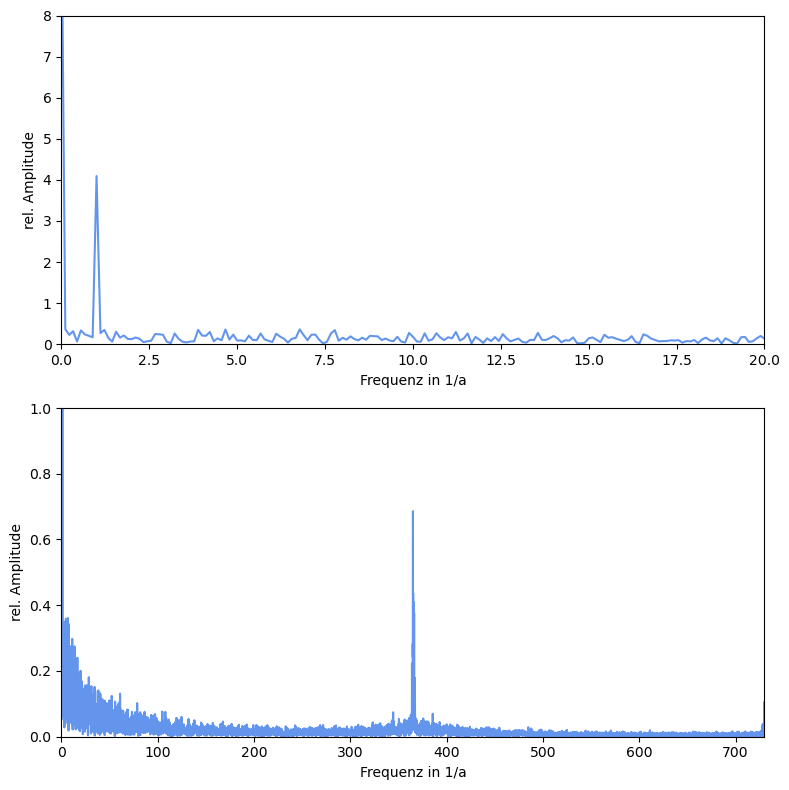

In [9]:
from scipy.fft import rfft, rfftfreq, irfft

amplitude = rfft(temp_grid, norm = "forward")
frequencies = rfftfreq(len(time_grid), distance)

fig, ax = plt.subplots(2,1, figsize=(8, 8))

ax[0].plot(frequencies, np.abs(amplitude), c = "cornflowerblue")
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 8)
ax[0].set_xlabel("Frequenz in 1/a")
ax[0].set_ylabel("rel. Amplitude")

ax[1].plot(frequencies, np.abs(amplitude), c = "cornflowerblue")
ax[1].set_xlim(0, 2*365)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel("Frequenz in 1/a")
ax[1].set_ylabel("rel. Amplitude")

fig.tight_layout()

## e)

Die charakteristischen Frequenzen sind wie erwartet 1 (Jahreszeiten) und 1/365 (Tag/Nacht Rhytmus).
Rücktransformation nach Isolation der 2 maximalen Frequenzen:

In [10]:
amplitude_new = np.copy(amplitude)
amplitude_new[np.abs(amplitude)<0.6] = 0 # kleine Amplituden vernachlässigen

inv_amplitude = irfft(amplitude_new, len(amplitude_new), norm = "forward")

x = np.linspace(2000, 2008.999981, 157681) # Linspace als Notlösung weil array nach Trafo nicht gleich lang

Plot der Resultate im Jahres- und Tagesbereich:

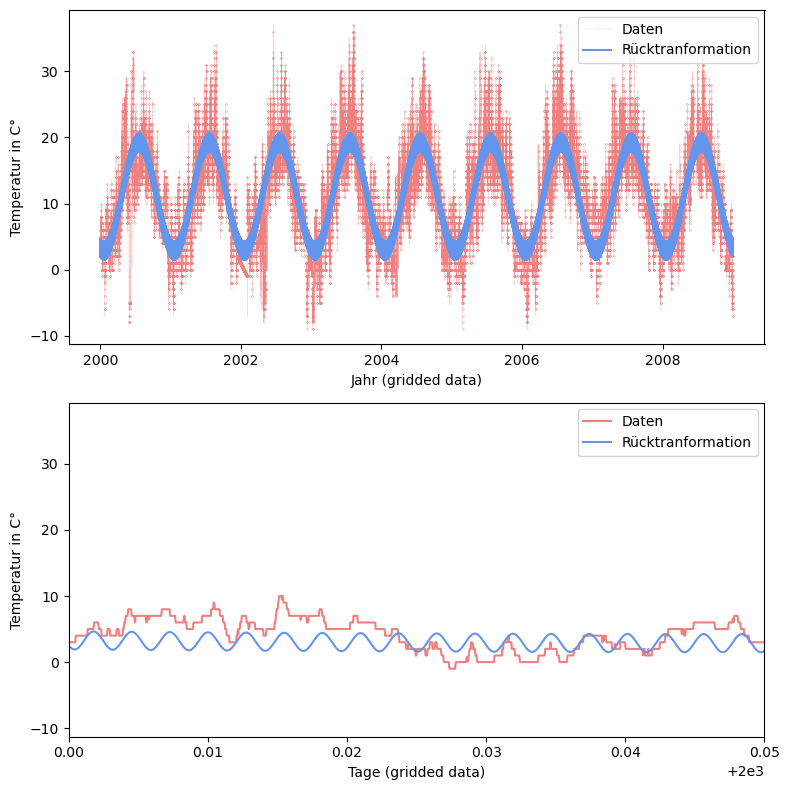

In [11]:
fig, ax = plt.subplots(2,1, figsize=(8, 8))

ax[0].plot(time_grid, temp_grid, marker = ".", ms = 0.1, lw = 0.1, c = "lightcoral", label ="Daten")
ax[0].plot(x, inv_amplitude, c = "cornflowerblue", label ="Rücktranformation")
ax[0].set_xlabel("Jahr (gridded data)")
ax[0].set_ylabel("Temperatur in C°")
ax[0].legend()

ax[1].plot(time_grid, temp_grid, c = "lightcoral", label ="Daten")
ax[1].plot(x, inv_amplitude, c = "cornflowerblue", label ="Rücktranformation")
ax[1].set_xlabel("Tage (gridded data)")
ax[1].set_ylabel("Temperatur in C°")
ax[1].set_xlim(2000,2000.05)
ax[1].legend()

fig.tight_layout()

# exercise 19

## a)
Das Nyqist-Shannon Theorem erfordet Frequenzen im Bereich $-\frac{\pi}{\Delta} \leq \omega \leq \frac{\pi}{\Delta}$, wobei $\Delta$ das Messzeitintervall ist. Dabei werden $n+1$ Frequenzen ermittelt.

## b)
Bei Messwerten mit unterschiedlichen Messzeitabständen oder fehlenden Werten müssen die Daten angepasst werden, da die Fourier Analyse nur bei Daten mit identischen Abständen funktioniert. Dies wird als gridding bezeichnet und ist problematisch, da es die Ergebnisse verfälscht werden aufgrund von Abweichungen der neu generierten Punkte von der Realität.

## c)
Bei einer Fast Fourier Transformation werden die zu berechnenden Summen nach dem Divide and Conquer Prinzip fortlaufend in 2 kleinere gleichgroße Summmen aufgeteilt, was die Laufzweit wesentlich verkürzt.

## d)
**Fourier Transformation**:
- gibt Amplitude und Phase zurück
- braucht äquidistante Datenpunkte
- numerisch sehr effizient
- kann invertiert werden

**Lomb-Scargle Periodogramm**:
- gibt nur Amplitudeninformation
- Datenpunkte egal
- Höhere Frequenzauflösung
- Ideal zur Ermittlung einer Frequenzkomponente

## e)
siehe d) ixde